This notebook tries to answer the reviewer's following comment:

> Also, were there OTUs that were present between all sites?!

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [71]:
outfile = '../../final/figures/reviewer.shared_otus_all_sites.png'

In [35]:
fmeta = '../../data/clean/rosen.metadata.clean'
fotu = '../../data/clean/rosen.otu_table.rel_abun.clean'

meta = pd.read_csv(fmeta, sep='\t', index_col=0)
df = pd.read_csv(fotu, sep='\t', index_col=0)

In [36]:
# Remove the 05 and second time point samples
samples = meta.index.tolist()

# Don't include samples from second time point or lung transplants
exclude = ['2', 'F', 'sick', 'F2T']
for s in exclude:
    samples = [i for i in samples if not i.endswith(s)]
samples = [i for i in samples if not i.startswith('05')]

# The two others which are Aim 5 (lung transplant) patients
samples = [i for i in samples if not i.startswith('dup')]
samples = [i for i in samples if not i.startswith('15-169-4')] 

meta = meta.loc[samples]

In [37]:
df_binary = (df > 0).astype(int)
df_binary.head()

,k__Bacteria;p__Firmicutes;c__Negativicutes;o__Selenomonadales;f__Acidaminococcaceae;g__Phascolarctobacterium;s__;d__denovo58,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Clostridiales_Incertae_Sedis_XIII;g__Anaerovorax;s__;d__denovo1106,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Ruminococcus2;s__;d__denovo57,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Actinomycetaceae;g__Actinomyces;s__;d__denovo886,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__;s__;d__denovo887,k__Bacteria;p__Proteobacteria;c__Betaproteobacteria;o__Neisseriales;f__Neisseriaceae;g__Neisseria;s__;d__denovo884,k__Bacteria;p__Firmicutes;c__Bacilli;o__Lactobacillales;f__Streptococcaceae;g__Streptococcus;s__;d__denovo885,k__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillales_Incertae_Sedis_XI;g__Gemella;s__;d__denovo882,k__Bacteria;p__Actinobacteria;c__Actinobacteria;o__Actinomycetales;f__Micrococcaceae;g__Rothia;s__;d__denovo883,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__;s__;d__denovo880,...,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Clostridium_XlVa;s__;d__denovo701,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Clostridium_IV;s__;d__denovo954,k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__;d__denovo955,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Ruminococcaceae;g__Pseudoflavonifractor;s__;d__denovo950,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Porphyromonadaceae;g__Barnesiella;s__;d__denovo951,k__Bacteria;p__Firmicutes;c__Clostridia;o__Clostridiales;f__Lachnospiraceae;g__Lachnospiracea_incertae_sedis;s__;d__denovo952,k__Bacteria;p__Fusobacteria;c__Fusobacteriia;o__Fusobacteriales;f__Fusobacteriaceae;g__Fusobacterium;s__;d__denovo953,k__Bacteria;p__Firmicutes;c__;o__;f__;g__;s__;d__denovo958,k__Bacteria;p__Bacteroidetes;c__Bacteroidia;o__Bacteroidales;f__Prevotellaceae;g__Prevotella;s__;d__denovo959,k__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Pasteurellales;f__Pasteurellaceae;g__Haemophilus;s__;d__denovo2432
01-112-7GI,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
01-112-7RI,1,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0
01-112-7TI,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
01-164-7GI,1,0,0,1,0,0,1,0,0,0,...,0,0,1,0,0,0,1,0,0,0
01-164-7RI,1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


We'll combine the OTU table and metadata to make a dataframe with the following format:

patient, otu_id, present_in BAL, present_in gastric, present_in throat

In [38]:
metacols = ['site', 'subject_id', 'mbs_consolidated']

combined = pd.merge(df_binary, meta[metacols], left_index=True, right_index=True)
keep_sites = ['bal', 'gastric_fluid', 'throat_swab']

combined = combined.query('site == @keep_sites')
combined.index.name = 'sample_id'
combined.shape

(421, 1581)

In [39]:
tidydf = combined.reset_index().melt(
    id_vars=metacols + ['sample_id'],
    var_name='otu_id', value_name='presence'
)

In [40]:
tidydf.head()

,site,subject_id,mbs_consolidated,sample_id,otu_id,presence
0,gastric_fluid,01-112-7,NaN,01-112-7GI,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,1
1,throat_swab,01-112-7,NaN,01-112-7TI,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0
2,gastric_fluid,01-164-7,NaN,01-164-7GI,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,1
3,throat_swab,01-164-7,NaN,01-164-7TI,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,0
4,gastric_fluid,01-173-4,NaN,01-173-4G,k__Bacteria;p__Firmicutes;c__Negativicutes;o__...,1


In [57]:
# Convert this into OTU, number of patients with that OTU present in all 3 sites

n_shared = []
for o, subdf in tidydf.groupby('otu_id'):
    n = sum(subdf.pivot(index='subject_id', columns='site', values='presence').dropna().sum(axis=1) == 3)
    n_shared.append([o, n])

In [58]:
shared_df = pd.DataFrame(n_shared, columns=['otu', 'n_patients_shared'])
shared_df.head()

,otu,n_patients_shared
0,k__;p__;c__;o__;f__;g__;s__;d__denovo120,0
1,k__Archaea;p__Euryarchaeota;c__Methanobacteria...,0
2,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1053,0
3,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1182,0
4,k__Bacteria;p__;c__;o__;f__;g__;s__;d__denovo1187,0


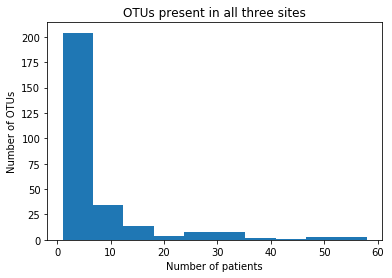

In [72]:
fig, ax = plt.subplots()

shared_df.query('n_patients_shared > 0').plot(kind='hist', ax=ax, legend=False)

ax.set_title('OTUs present in all three sites')
ax.set_ylabel('Number of OTUs')
ax.set_xlabel('Number of patients')

fig.savefig(outfile)

In [68]:
shared_df['n_patients_shared'].value_counts()

0     1297
1      105
2       37
3       23
6       15
5       13
7       12
4       11
8        7
12       6
13       6
9        4
11       4
14       4
34       3
29       3
17       2
15       2
19       2
53       2
35       2
47       2
30       2
24       2
25       1
26       1
10       1
28       1
20       1
32       1
37       1
40       1
46       1
23       1
49       1
58       1
Name: n_patients_shared, dtype: int64

In [70]:
sum(shared_df['n_patients_shared'] > 20)

26